In [ ]:
#!pip install torch torchvision timm numpy matplotlib

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm

First, we load the CIFAR-10 dataset and pick a single image to demonstrate the process.



100%|██████████| 170M/170M [00:05<00:00, 31.7MB/s] 


Selected image tensor shape: torch.Size([3, 32, 32])


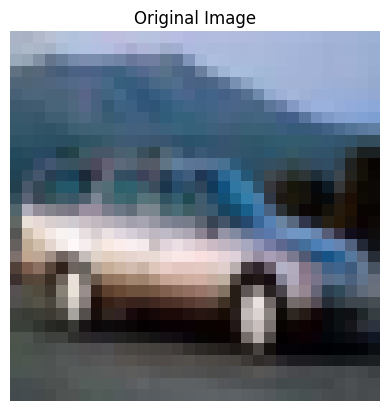

In [3]:

transform = transforms.ToTensor()
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

image_tensor, label = cifar_dataset[4]

print("Selected image tensor shape:", image_tensor.shape)

# plot imge
plt.imshow(image_tensor.permute(1, 2, 0))
plt.title("Original Image")
plt.axis('off')
plt.show()

Next, we take the image tensor and slice it into 16 non-overlapping 8x8 patches.



In [4]:
PATCH_SIZE = 8
NUM_PATCHES = (32 // PATCH_SIZE)**2 # 16 patches

patches = image_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

# Reshape(NumPatches, Channels, PatchH, PatchW)
patches = patches.permute(1, 2, 0, 3, 4).reshape(NUM_PATCHES, 3, PATCH_SIZE, PATCH_SIZE)

modified_patches = patches.clone()

print(f"Created {NUM_PATCHES} patches.")
print("Shape of the patches tensor:", patches.shape)

Created 16 patches.
Shape of the patches tensor: torch.Size([16, 3, 8, 8])


Now we randomly select half of the patches (8 of them) to be in our "Set A".



In [5]:
NUM_SET_A = NUM_PATCHES // 2 # 8 patches

all_indices = torch.randperm(NUM_PATCHES)

set_A_indices = all_indices[:NUM_SET_A]

print("Indices of all patches: ", all_indices.tolist())
print("Randomly selected indices for Set A:", set_A_indices.tolist())

Indices of all patches:  [13, 4, 14, 8, 10, 9, 6, 5, 3, 2, 11, 1, 15, 7, 12, 0]
Randomly selected indices for Set A: [13, 4, 14, 8, 10, 9, 6, 5]


From the 8 patches in Set A, we'll randomly choose 4 to mask by setting their pixel values to zero.



In [6]:
NUM_TO_MASK = NUM_SET_A // 2 # 4 patch
shuffled_set_A = set_A_indices[torch.randperm(len(set_A_indices))]

mask_indices = shuffled_set_A[:NUM_TO_MASK]

rotate_indices = shuffled_set_A[NUM_TO_MASK:]

for idx in mask_indices:
    modified_patches[idx].fill_(0)

print("Indices from Set A chosen for MASKING:", mask_indices.tolist())
print("Indices from Set A chosen for ROTATION:", rotate_indices.tolist())

Indices from Set A chosen for MASKING: [14, 5, 13, 10]
Indices from Set A chosen for ROTATION: [9, 8, 4, 6]


In [7]:

rotation_angles = [0, 90, 180, 270]

random_angle = int(np.random.choice(rotation_angles))

for idx in rotate_indices:
    modified_patches[idx] = TF.rotate(modified_patches[idx], random_angle)

print(f"Applied a rotation of {random_angle} degrees to the remaining patches in Set A.")

Applied a rotation of 270 degrees to the remaining patches in Set A.


Finally, we apply a single random rotation to the other 4 patches in Set A.



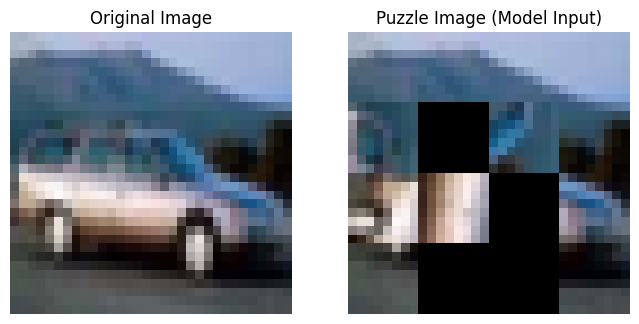

In [8]:

modified_patches_grid = modified_patches.reshape(4, 4, 3, PATCH_SIZE, PATCH_SIZE)
puzzle_image = modified_patches_grid.permute(2, 0, 3, 1, 4).reshape(3, 32, 32)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(image_tensor.permute(1, 2, 0))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(puzzle_image.permute(1, 2, 0))
axes[1].set_title("Puzzle Image (Model Input)")
axes[1].axis('off')

plt.show()


> ii) Append a CLS token. On this token, apply a linear layer which can classifythe rotation of the rotated patches. You need to classify into one of the fourclasses.> 


In [9]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 8
IMG_SIZE = 32
EMBED_DIM = 256 
NUM_TRANSFORMER_BLOCKS = 2

In [10]:

class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Conv2d(3, EMBED_DIM, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
    def forward(self, x):
        return self.proj(x).flatten(2).transpose(1, 2)

class StudentEncoder(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        num_patches = (IMG_SIZE // PATCH_SIZE) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, EMBED_DIM))
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBED_DIM, nhead=num_heads, dim_feedforward=EMBED_DIM * 4, dropout=0.1, activation='gelu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_TRANSFORMER_BLOCKS)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        
        return self.transformer_encoder(x)

### --- Load the SSL _encoder from assignement 1 ---

### 1. Create an instance of your StudentEncoder class
### We are using 4 heads because we saved the 4-head model in the last assignment

In [11]:

NUM_HEADS = 4
ssl_encoder = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)

ssl_encoder.load_state_dict(torch.load('/kaggle/input/ssl/pytorch/default/1/ssl_student_encoder_4_heads.pth', map_location=DEVICE))

✅ Success! The 'ssl_encoder' variable has been created and weights are loaded.


#### --- Create the Data Pipeline (Dataset and DataLoader) ---

#### 1. Define the custom transform from Q1(i)

In [12]:

class MaskAndRotateImageTransform:
    def __init__(self, patch_size=8):
        self.patch_size = patch_size
        self.num_patches = (IMG_SIZE // patch_size)**2
        self.num_select = self.num_patches // 2
        self.num_mask = self.num_select // 2
        self.angles = [0, 90, 180, 270]
        self.to_tensor = transforms.ToTensor()
        self.normalizer = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

    def __call__(self, img):
        img_tensor = self.to_tensor(img)
        original_img_tensor = img_tensor.clone()
        patches = img_tensor.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.permute(1, 2, 0, 3, 4).reshape(self.num_patches, 3, self.patch_size, self.patch_size)
        all_indices = torch.randperm(self.num_patches)
        mask_indices = all_indices[:self.num_mask]
        rotate_indices = all_indices[self.num_mask:self.num_select]
        for idx in mask_indices: patches[idx].fill_(0)
        rotation_label = torch.randint(0, len(self.angles), (1,)).item()
        angle = self.angles[rotation_label]
        for idx in rotate_indices: patches[idx] = TF.rotate(patches[idx], angle)
        p, c, ph, pw = patches.shape
        h, w = ph * (IMG_SIZE // ph), pw * (IMG_SIZE // pw)
        puzzle_img = patches.reshape(IMG_SIZE//ph, IMG_SIZE//pw, c, ph, pw).permute(2, 0, 3, 1, 4).reshape(c, h, w)
        return (self.normalizer(puzzle_img), self.normalizer(original_img_tensor), torch.tensor(rotation_label, dtype=torch.long), mask_indices)

# Dataset Wrapper
class SSLDatasetWrapper(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image, label = self.base_dataset[self.indices[idx]]
        return self.transform(image)

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
targets = np.array(full_train_dataset.targets)
class_indices = defaultdict(list)
for i, target in enumerate(targets): class_indices[target].append(i)
np.random.seed(42)
student_indices = []
for i in range(10): student_indices.extend(np.random.choice(class_indices[i], 100, replace=False))

base_cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None)
ssl_train_dataset = SSLDatasetWrapper(base_cifar_dataset, student_indices, MaskAndRotateImageTransform())
ssl_train_loader = DataLoader(ssl_train_dataset, batch_size=32, shuffle=True, num_workers=2)


✅ Success! The 'ssl_train_loader' has been created.


In [13]:
import torch
import torch.nn as nn


class ModelMWithHeads(nn.Module):
    """
    This model combines the logic for both Q1(ii) and Q1(iii).
    It takes the pre-trained encoder and adds two separate prediction heads.
    """
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        
        self.rotation_head = nn.Linear(EMBED_DIM, 4)

        self.reconstruction_head = nn.Linear(EMBED_DIM, 3 * PATCH_SIZE * PATCH_SIZE)

    def forward(self, x, mask_indices):
        """
        The forward pass takes the puzzle image and the indices of the masked patches.
        """

        all_token_embeddings = self.encoder(x)
        
        cls_token_embedding = all_token_embeddings[:, 0]
        rotation_logits = self.rotation_head(cls_token_embedding)
        
        batch_size = all_token_embeddings.shape[0]
        batch_indices = torch.arange(batch_size, device=x.device).unsqueeze(1)

        masked_token_embeddings = all_token_embeddings[batch_indices, mask_indices + 1]
        
        reconstructed_patches = self.reconstruction_head(masked_token_embeddings)
        
        return rotation_logits, reconstructed_patches


model_m = ModelMWithHeads(ssl_encoder).to(DEVICE)

Successfully created the combined model for parts (ii) and (iii).
ModelMWithHeads(
  (encoder): StudentEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (rotation_head): Linear(in

In [14]:

class ModelMWithHeads(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.rotation_head = nn.Linear(EMBED_DIM, 4)
        self.reconstruction_head = nn.Linear(EMBED_DIM, 3 * PATCH_SIZE * PATCH_SIZE)

    def forward(self, x, mask_indices):
        all_token_embeddings = self.encoder(x)
        cls_token_embedding = all_token_embeddings[:, 0]
        rotation_logits = self.rotation_head(cls_token_embedding)
        batch_size = all_token_embeddings.shape[0]
        batch_indices = torch.arange(batch_size, device=x.device).unsqueeze(1)
        masked_token_embeddings = all_token_embeddings[batch_indices, mask_indices + 1]
        reconstructed_patches = self.reconstruction_head(masked_token_embeddings)
        return rotation_logits, reconstructed_patches

model_m = ModelMWithHeads(ssl_encoder).to(DEVICE)


✅ Success! The 'model_m' has been created.


### --- Q1(iv): TRAIN THE MODEL (Model M) ---

In [15]:

optimizer = optim.Adam(model_m.parameters(), lr=1e-4, weight_decay=1e-5)
rotation_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()

print("--- Starting Training for Model M ---")
model_m.train()

for epoch in range(20): 
    total_loss = 0
    correct_rotations = 0
    total_samples = 0

    for puzzle_img, orig_img, rot_label, mask_indices in tqdm(ssl_train_loader, desc=f"Epoch {epoch+1}/20"):
        puzzle_img, orig_img, rot_label, mask_indices = puzzle_img.to(DEVICE), orig_img.to(DEVICE), rot_label.to(DEVICE), mask_indices.to(DEVICE)

        rotation_logits, reconstructed_patches = model_m(puzzle_img, mask_indices)
        
        orig_patches = orig_img.unfold(2, PATCH_SIZE, PATCH_SIZE).unfold(3, PATCH_SIZE, PATCH_SIZE)
        orig_patches = orig_patches.permute(0, 2, 3, 1, 4, 5).reshape(orig_img.shape[0], -1, 3 * PATCH_SIZE * PATCH_SIZE)
        batch_indices = torch.arange(orig_img.shape[0], device=DEVICE).unsqueeze(1)
        target_patches = orig_patches[batch_indices, mask_indices]

        loss_rotation = rotation_criterion(rotation_logits, rot_label)
        loss_reconstruction = reconstruction_criterion(reconstructed_patches, target_patches)
        loss = loss_rotation + loss_reconstruction
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted = torch.max(rotation_logits.data, 1)
        total_samples += rot_label.size(0)
        correct_rotations += (predicted == rot_label).sum().item()
        # -------------------------------------------
        
    epoch_loss = total_loss / len(ssl_train_loader)
    epoch_acc = 100 * correct_rotations / total_samples
    print(f"Epoch {epoch+1} Average Loss: {epoch_loss:.4f} | Rotation Accuracy: {epoch_acc:.2f}%")
    # -----------------------------------

torch.save(model_m.encoder.state_dict(), 'model_m_encoder.pth')
print("\n✅ Training complete. Saved Model M's encoder weights to 'model_m_encoder.pth'.")

--- Starting Training for Model M ---


Epoch 1/20: 100%|██████████| 32/32 [00:02<00:00, 14.91it/s]


Epoch 1 Average Loss: 3.1400 | Rotation Accuracy: 25.50%


Epoch 2/20: 100%|██████████| 32/32 [00:00<00:00, 36.24it/s]


Epoch 2 Average Loss: 2.8205 | Rotation Accuracy: 24.90%


Epoch 3/20: 100%|██████████| 32/32 [00:00<00:00, 37.27it/s]


Epoch 3 Average Loss: 2.6875 | Rotation Accuracy: 25.20%


Epoch 4/20: 100%|██████████| 32/32 [00:00<00:00, 35.95it/s]


Epoch 4 Average Loss: 2.6235 | Rotation Accuracy: 27.20%


Epoch 5/20: 100%|██████████| 32/32 [00:00<00:00, 34.79it/s]


Epoch 5 Average Loss: 2.5754 | Rotation Accuracy: 26.60%


Epoch 6/20: 100%|██████████| 32/32 [00:00<00:00, 36.35it/s]


Epoch 6 Average Loss: 2.5535 | Rotation Accuracy: 24.80%


Epoch 7/20: 100%|██████████| 32/32 [00:00<00:00, 36.21it/s]


Epoch 7 Average Loss: 2.5027 | Rotation Accuracy: 26.80%


Epoch 8/20: 100%|██████████| 32/32 [00:00<00:00, 33.01it/s]


Epoch 8 Average Loss: 2.4556 | Rotation Accuracy: 28.80%


Epoch 9/20: 100%|██████████| 32/32 [00:00<00:00, 32.79it/s]


Epoch 9 Average Loss: 2.4562 | Rotation Accuracy: 29.60%


Epoch 10/20: 100%|██████████| 32/32 [00:00<00:00, 37.26it/s]


Epoch 10 Average Loss: 2.4542 | Rotation Accuracy: 27.80%


Epoch 11/20: 100%|██████████| 32/32 [00:00<00:00, 36.70it/s]


Epoch 11 Average Loss: 2.4321 | Rotation Accuracy: 31.40%


Epoch 12/20: 100%|██████████| 32/32 [00:00<00:00, 35.45it/s]


Epoch 12 Average Loss: 2.3938 | Rotation Accuracy: 31.40%


Epoch 13/20: 100%|██████████| 32/32 [00:00<00:00, 34.64it/s]


Epoch 13 Average Loss: 2.3286 | Rotation Accuracy: 34.60%


Epoch 14/20: 100%|██████████| 32/32 [00:00<00:00, 35.74it/s]


Epoch 14 Average Loss: 2.3375 | Rotation Accuracy: 34.90%


Epoch 15/20: 100%|██████████| 32/32 [00:00<00:00, 36.23it/s]


Epoch 15 Average Loss: 2.3155 | Rotation Accuracy: 33.30%


Epoch 16/20: 100%|██████████| 32/32 [00:00<00:00, 36.25it/s]


Epoch 16 Average Loss: 2.2966 | Rotation Accuracy: 37.10%


Epoch 17/20: 100%|██████████| 32/32 [00:00<00:00, 35.30it/s]


Epoch 17 Average Loss: 2.2703 | Rotation Accuracy: 35.70%


Epoch 18/20: 100%|██████████| 32/32 [00:00<00:00, 36.62it/s]


Epoch 18 Average Loss: 2.2849 | Rotation Accuracy: 34.40%


Epoch 19/20: 100%|██████████| 32/32 [00:00<00:00, 33.87it/s]


Epoch 19 Average Loss: 2.2159 | Rotation Accuracy: 39.20%


Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 32.90it/s]

Epoch 20 Average Loss: 2.2195 | Rotation Accuracy: 38.10%

✅ Training complete. Saved Model M's encoder weights to 'model_m_encoder.pth'.


### --- Q1(v): Define the Fine-tuning Model ---
#### This is the new linear layer that replaces the old ones.
### It takes the CLS token embedding and outputs predictions for the 10 CIFAR classes.

In [16]:


class ClassificationModel(nn.Module):
    def __init__(self, encoder):
        """
        Initializes the model for fine-tuning.
        Args:
            encoder (nn.Module): The SSL-trained 'Model M' encoder.
        """
        super().__init__()
        self.encoder = encoder
        
        self.classifier_head = nn.Linear(EMBED_DIM, 10)

    def forward(self, x):
        """
        Defines the forward pass for classification.
        """
        all_token_embeddings = self.encoder(x)
        cls_token_embedding = all_token_embeddings[:, 0]
        logits = self.classifier_head(cls_token_embedding)
        
        return logits


trained_encoder_m = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)

trained_encoder_m.load_state_dict(torch.load('model_m_encoder.pth', map_location=DEVICE))

finetune_model = ClassificationModel(encoder=trained_encoder_m).to(DEVICE)


✅ Successfully created the classification model for fine-tuning.
ClassificationModel(
  (encoder): StudentEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (classifier_head): Line

##### --- Q1(v): Prepare DataLoaders for Fine-tuning ---

##### Define a standard transformation pipeline with simple augmentations

In [17]:

finetune_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

finetune_dataset = Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, transform=finetune_transform),
    student_indices  
)

finetune_loader = DataLoader(finetune_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
test_loader = DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform),
    batch_size=32
)


✅ DataLoaders for fine-tuning are ready.


#### --- Q1(v): Fine-tune and Evaluate the Model ---

In [18]:

optimizer_ft = optim.Adam(finetune_model.parameters(), lr=5e-5, weight_decay=1e-4)
criterion_ft = nn.CrossEntropyLoss()

print("--- Starting Fine-tuning ---")
finetune_model.train() 

for epoch in range(50): 
    total_loss = 0
    for images, labels in tqdm(finetune_loader, desc=f"Finetune Epoch {epoch+1}/50"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass
        outputs = finetune_model(images)
        loss = criterion_ft(outputs, labels)
        
        # Backward pass and optimization
        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(finetune_loader):.4f}")

finetune_model.eval() 
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = finetune_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"\n  Fine-tuned Model Accuracy: {100 * correct / total:.2f}%")

--- Starting Fine-tuning ---


Finetune Epoch 1/50: 100%|██████████| 32/32 [00:00<00:00, 69.37it/s]


Epoch 1 Average Loss: 2.2399


Finetune Epoch 2/50: 100%|██████████| 32/32 [00:00<00:00, 69.89it/s]


Epoch 2 Average Loss: 1.9961


Finetune Epoch 3/50: 100%|██████████| 32/32 [00:00<00:00, 67.38it/s]


Epoch 3 Average Loss: 1.8753


Finetune Epoch 4/50: 100%|██████████| 32/32 [00:00<00:00, 68.18it/s]


Epoch 4 Average Loss: 1.7843


Finetune Epoch 5/50: 100%|██████████| 32/32 [00:00<00:00, 67.30it/s]


Epoch 5 Average Loss: 1.6949


Finetune Epoch 6/50: 100%|██████████| 32/32 [00:00<00:00, 66.65it/s]


Epoch 6 Average Loss: 1.6484


Finetune Epoch 7/50: 100%|██████████| 32/32 [00:00<00:00, 65.44it/s]


Epoch 7 Average Loss: 1.5878


Finetune Epoch 8/50: 100%|██████████| 32/32 [00:00<00:00, 62.18it/s]


Epoch 8 Average Loss: 1.5482


Finetune Epoch 9/50: 100%|██████████| 32/32 [00:00<00:00, 66.13it/s]


Epoch 9 Average Loss: 1.5078


Finetune Epoch 10/50: 100%|██████████| 32/32 [00:00<00:00, 66.80it/s]


Epoch 10 Average Loss: 1.4668


Finetune Epoch 11/50: 100%|██████████| 32/32 [00:00<00:00, 66.07it/s]


Epoch 11 Average Loss: 1.4420


Finetune Epoch 12/50: 100%|██████████| 32/32 [00:00<00:00, 67.18it/s]


Epoch 12 Average Loss: 1.3980


Finetune Epoch 13/50: 100%|██████████| 32/32 [00:00<00:00, 67.34it/s]


Epoch 13 Average Loss: 1.4020


Finetune Epoch 14/50: 100%|██████████| 32/32 [00:00<00:00, 66.05it/s]


Epoch 14 Average Loss: 1.3305


Finetune Epoch 15/50: 100%|██████████| 32/32 [00:00<00:00, 66.32it/s]


Epoch 15 Average Loss: 1.3249


Finetune Epoch 16/50: 100%|██████████| 32/32 [00:00<00:00, 66.61it/s]


Epoch 16 Average Loss: 1.2751


Finetune Epoch 17/50: 100%|██████████| 32/32 [00:00<00:00, 63.64it/s]


Epoch 17 Average Loss: 1.2526


Finetune Epoch 18/50: 100%|██████████| 32/32 [00:00<00:00, 61.65it/s]


Epoch 18 Average Loss: 1.2227


Finetune Epoch 19/50: 100%|██████████| 32/32 [00:00<00:00, 66.14it/s]


Epoch 19 Average Loss: 1.1798


Finetune Epoch 20/50: 100%|██████████| 32/32 [00:00<00:00, 64.57it/s]


Epoch 20 Average Loss: 1.1611


Finetune Epoch 21/50: 100%|██████████| 32/32 [00:00<00:00, 64.83it/s]


Epoch 21 Average Loss: 1.1433


Finetune Epoch 22/50: 100%|██████████| 32/32 [00:00<00:00, 65.62it/s]


Epoch 22 Average Loss: 1.0993


Finetune Epoch 23/50: 100%|██████████| 32/32 [00:00<00:00, 66.01it/s]


Epoch 23 Average Loss: 1.0782


Finetune Epoch 24/50: 100%|██████████| 32/32 [00:00<00:00, 66.81it/s]


Epoch 24 Average Loss: 1.0551


Finetune Epoch 25/50: 100%|██████████| 32/32 [00:00<00:00, 66.11it/s]


Epoch 25 Average Loss: 1.0125


Finetune Epoch 26/50: 100%|██████████| 32/32 [00:00<00:00, 66.62it/s]


Epoch 26 Average Loss: 1.0217


Finetune Epoch 27/50: 100%|██████████| 32/32 [00:00<00:00, 66.69it/s]


Epoch 27 Average Loss: 0.9949


Finetune Epoch 28/50: 100%|██████████| 32/32 [00:00<00:00, 66.20it/s]


Epoch 28 Average Loss: 0.9810


Finetune Epoch 29/50: 100%|██████████| 32/32 [00:00<00:00, 65.64it/s]


Epoch 29 Average Loss: 0.9166


Finetune Epoch 30/50: 100%|██████████| 32/32 [00:00<00:00, 71.49it/s]


Epoch 30 Average Loss: 0.9126


Finetune Epoch 31/50: 100%|██████████| 32/32 [00:00<00:00, 71.25it/s]


Epoch 31 Average Loss: 0.8994


Finetune Epoch 32/50: 100%|██████████| 32/32 [00:00<00:00, 67.19it/s]


Epoch 32 Average Loss: 0.8850


Finetune Epoch 33/50: 100%|██████████| 32/32 [00:00<00:00, 65.82it/s]


Epoch 33 Average Loss: 0.8752


Finetune Epoch 34/50: 100%|██████████| 32/32 [00:00<00:00, 66.14it/s]


Epoch 34 Average Loss: 0.8239


Finetune Epoch 35/50: 100%|██████████| 32/32 [00:00<00:00, 66.91it/s]


Epoch 35 Average Loss: 0.7844


Finetune Epoch 36/50: 100%|██████████| 32/32 [00:00<00:00, 67.38it/s]


Epoch 36 Average Loss: 0.7933


Finetune Epoch 37/50: 100%|██████████| 32/32 [00:00<00:00, 67.29it/s]


Epoch 37 Average Loss: 0.7586


Finetune Epoch 38/50: 100%|██████████| 32/32 [00:00<00:00, 62.33it/s]


Epoch 38 Average Loss: 0.7291


Finetune Epoch 39/50: 100%|██████████| 32/32 [00:00<00:00, 63.47it/s]


Epoch 39 Average Loss: 0.6874


Finetune Epoch 40/50: 100%|██████████| 32/32 [00:00<00:00, 67.10it/s]


Epoch 40 Average Loss: 0.6722


Finetune Epoch 41/50: 100%|██████████| 32/32 [00:00<00:00, 62.93it/s]


Epoch 41 Average Loss: 0.6579


Finetune Epoch 42/50: 100%|██████████| 32/32 [00:00<00:00, 65.90it/s]


Epoch 42 Average Loss: 0.6597


Finetune Epoch 43/50: 100%|██████████| 32/32 [00:00<00:00, 62.33it/s]


Epoch 43 Average Loss: 0.6428


Finetune Epoch 44/50: 100%|██████████| 32/32 [00:00<00:00, 66.81it/s]


Epoch 44 Average Loss: 0.6746


Finetune Epoch 45/50: 100%|██████████| 32/32 [00:00<00:00, 66.82it/s]


Epoch 45 Average Loss: 0.6111


Finetune Epoch 46/50: 100%|██████████| 32/32 [00:00<00:00, 66.90it/s]


Epoch 46 Average Loss: 0.5803


Finetune Epoch 47/50: 100%|██████████| 32/32 [00:00<00:00, 65.91it/s]


Epoch 47 Average Loss: 0.6216


Finetune Epoch 48/50: 100%|██████████| 32/32 [00:00<00:00, 67.41it/s]


Epoch 48 Average Loss: 0.5530


Finetune Epoch 49/50: 100%|██████████| 32/32 [00:00<00:00, 64.96it/s]


Epoch 49 Average Loss: 0.5239


Finetune Epoch 50/50: 100%|██████████| 32/32 [00:00<00:00, 66.95it/s]


Epoch 50 Average Loss: 0.5414

✅ Final Fine-tuned Model Accuracy: 40.29%


In [19]:

def plot_similarity_maps(encoder_model, dataset, num_samples=3, title="Similarity Maps"):
    """
    Computes and plots the cosine similarity between the [CLS] token and all patch tokens.
    """
    encoder_model.eval() 
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 4 * num_samples))
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        image_for_plot = image.permute(1, 2, 0) 
        
        with torch.no_grad():
            token_embeddings = encoder_model(image.unsqueeze(0).to(DEVICE))
            
        token_embeddings = token_embeddings.squeeze(0)
        cls_embedding = token_embeddings[0]
        patch_embeddings = token_embeddings[1:]
        cls_embedding_norm = F.normalize(cls_embedding, dim=0)
        patch_embeddings_norm = F.normalize(patch_embeddings, dim=0)
        
        similarities = torch.matmul(patch_embeddings_norm, cls_embedding_norm)
        
        similarity_map = similarities.reshape(4, 4).cpu().numpy()

        # --- Plotting ---
        #  original image
        ax = axes[i, 0]
        ax.imshow(image_for_plot)
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')
        
        # upsampled similarity map
        ax = axes[i, 1]
        im = ax.imshow(similarity_map, cmap='viridis', interpolation='nearest')
        ax.set_title(f"4x4 Similarity to [CLS]")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


✅ Visualization function 'plot_similarity_maps' is defined.


#### --- Visualization BEFORE Fine-tuning ---

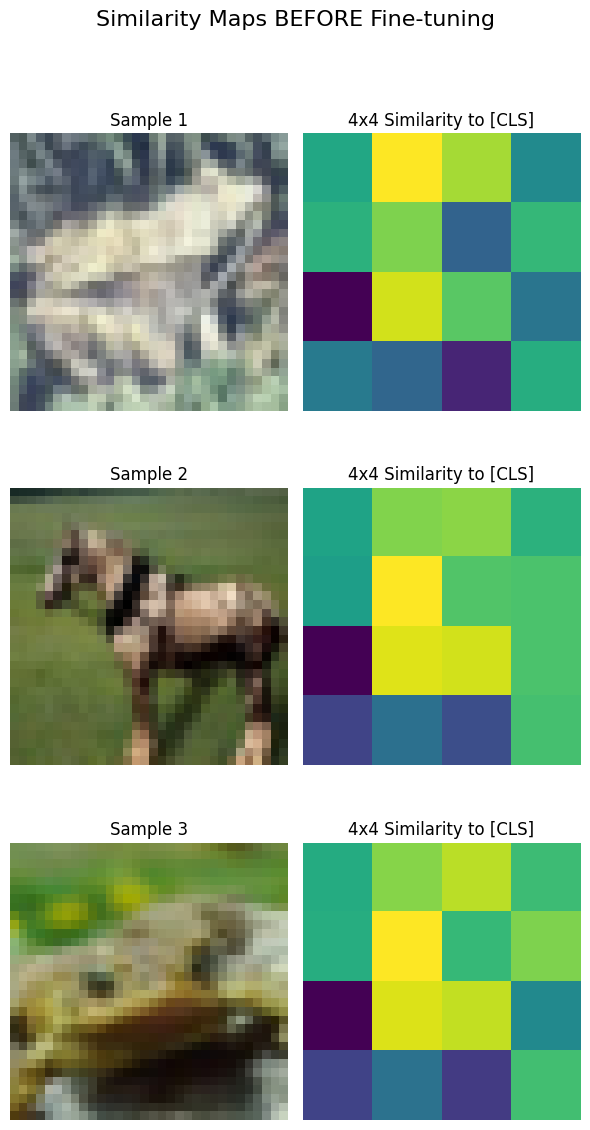

In [20]:

encoder_before_ft = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)
encoder_before_ft.load_state_dict(torch.load('model_m_encoder.pth', map_location=DEVICE))

test_dataset_for_viz = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor()
)

plot_similarity_maps(
    encoder_before_ft, 
    test_dataset_for_viz, 
    num_samples=3, 
    title="Similarity Maps BEFORE Fine-tuning"
)

#### --- Visualization AFTER Fine-tuning ---

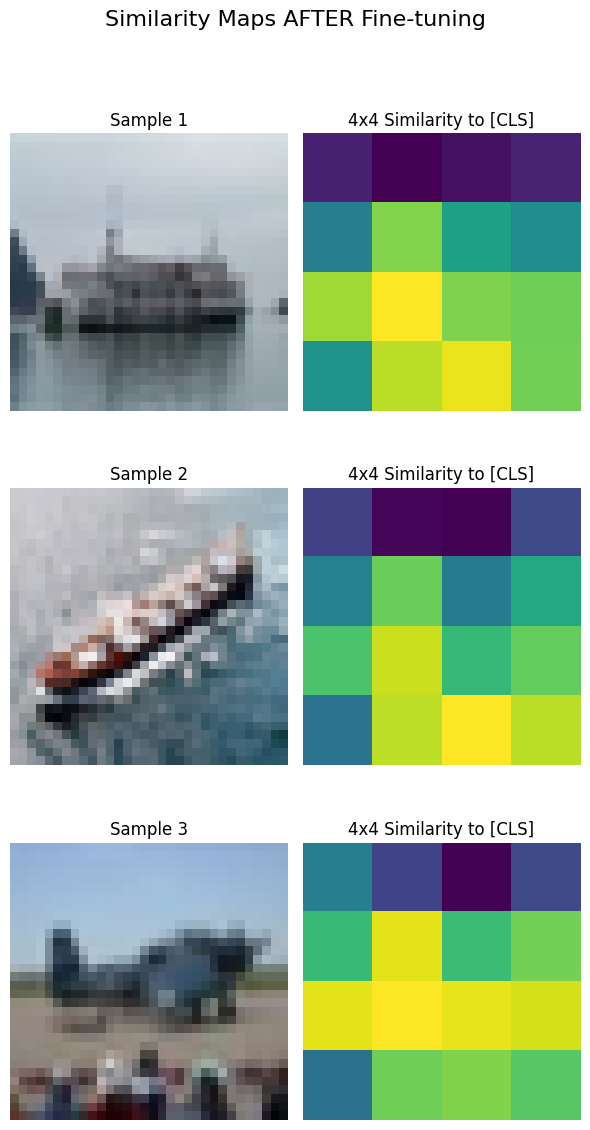

In [21]:

encoder_after_ft = finetune_model.encoder

plot_similarity_maps(
    encoder_after_ft, 
    test_dataset_for_viz, 
    num_samples=3, 
    title="Similarity Maps AFTER Fine-tuning"
)

### --- Q1(vii): CKA Implementation ---

In [22]:


def cka_similarity(X, Y):
    """
    Computes Centered Kernel Alignment (CKA) similarity.
    
    Args:
        X (torch.Tensor): Feature matrix of shape (num_samples, num_features).
        Y (torch.Tensor): Feature matrix of shape (num_samples, num_features).
        
    Returns:
        float: The CKA similarity score.
    """
    X = X - X.mean(dim=0)
    Y = Y - Y.mean(dim=0)

    K = X @ X.T
    L = Y @ Y.T

    hsic = torch.sum(K * L)
    var1 = torch.sqrt(torch.sum(K * K))
    var2 = torch.sqrt(torch.sum(L * L))

    return (hsic / (var1 * var2)).item()


✅ CKA similarity function is defined.


#### --- Q1(vii): Extract Features and Compute CKA ---

In [23]:


def get_cka_for_model(encoder, data_loader):
    """
    Extracts features before/after the final attention block and computes CKA.
    """
    encoder.eval()
    
    features_before_final_attn = []
    features_after_final_attn = []
    
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(DEVICE)
        
        x = encoder.patch_embed(images)
        cls_tokens = encoder.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += encoder.pos_embed
        
        for i in range(NUM_TRANSFORMER_BLOCKS - 1):
            x = encoder.transformer_encoder.layers[i](x)
            
        final_layer = encoder.transformer_encoder.layers[-1]
        
        x_before_attn = x
        
        norm1_out = final_layer.norm1(x_before_attn)
        attn_out = final_layer.self_attn(norm1_out, norm1_out, norm1_out)[0]
        x_after_attn = x_before_attn + attn_out
        
        features_before_final_attn = x_before_attn[:, 0, :]
        features_after_final_attn = x_after_attn[:, 0, :]

    cka_score = cka_similarity(features_before_final_attn, features_after_final_attn)
    return cka_score


#  Compute for the model BEFORE fine-tuning
encoder_before_ft = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)
encoder_before_ft.load_state_dict(torch.load('model_m_encoder.pth', map_location=DEVICE))
cka_before = get_cka_for_model(encoder_before_ft, test_loader)
print(f"CKA Similarity (Before Fine-tuning): {cka_before:.4f}")


#  Compute for the model AFTER fine-tuning
encoder_after_ft = finetune_model.encoder
cka_after = get_cka_for_model(encoder_after_ft, test_loader)
print(f"CKA Similarity (After Fine-tuning):  {cka_after:.4f}")

CKA Similarity (Before Fine-tuning): 0.8698
CKA Similarity (After Fine-tuning):  0.7353


Q2. [5]
Using the trained model M from step iv of Q1, do the following
i) Apply the factorised spatio-temporal attention
ii) First, initialize both spatial and temporal block with M. One spatial block
and one temporal block will suffice. This is one spatio-temporal block.

In [24]:


class FactorisedSpatioTemporalBlock(nn.Module):
    """
    A model containing a single factorised spatio-temporal block.
    The spatial and temporal layers are both initialized with weights from Model M.
    
    Args:
        pretrained_encoder (nn.Module): The SSL-trained 'Model M' encoder.
        num_frames (int): The number of frames in each video clip.
    """
    def __init__(self, pretrained_encoder, num_frames=8):
        super().__init__()
        
        self.patch_embed = pretrained_encoder.patch_embed
        self.pos_embed = pretrained_encoder.pos_embed 
        
        self.temporal_embed = nn.Parameter(torch.randn(1, num_frames, EMBED_DIM))
        self.spatial_block = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, nhead=NUM_HEADS, dim_feedforward=EMBED_DIM * 4,
            dropout=0.1, activation='gelu', batch_first=True
        )
        self.temporal_block = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, nhead=NUM_HEADS, dim_feedforward=EMBED_DIM * 4,
            dropout=0.1, activation='gelu', batch_first=True
        )
        pretrained_layer_state_dict = pretrained_encoder.transformer_encoder.layers[0].state_dict()
        
        self.spatial_block.load_state_dict(pretrained_layer_state_dict)
        self.temporal_block.load_state_dict(pretrained_layer_state_dict)
        
    def forward(self, x):
        # Input shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        num_patches = (H // PATCH_SIZE) * (W // PATCH_SIZE)
        x = x.reshape(B * T, C, H, W)
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :] # Shape: (B*T, N, D)
        
        x = self.spatial_block(x)
        x = x.reshape(B, T, num_patches, -1).permute(0, 2, 1, 3).reshape(B * num_patches, T, -1)
        x = x + self.temporal_embed
        x = self.temporal_block(x)
        
        x = x.reshape(B, num_patches, T, -1).permute(0, 2, 1, 3).reshape(B * T, num_patches, -1)
        return x.reshape(B, T * num_patches, -1)


✅ FactorisedSpatioTemporalBlock class is defined.


### 1. Load the pre-trained encoder (Model M) again to ensure a clean start

In [25]:

encoder_m = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)
encoder_m.load_state_dict(torch.load('model_m_encoder.pth', map_location=DEVICE))

NUM_FRAMES = 8
single_block_model = FactorisedSpatioTemporalBlock(
    pretrained_encoder=encoder_m, 
    num_frames=NUM_FRAMES
).to(DEVICE)


dummy_video_clip = torch.randn(2, NUM_FRAMES, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
print(f"\nInput dummy video shape: {dummy_video_clip.shape}")

single_block_model.eval()
with torch.no_grad():
    output_features = single_block_model(dummy_video_clip)


Loaded pre-trained Model M encoder.

✅ Successfully created the new single-block model.

Input dummy video shape: torch.Size([2, 8, 3, 32, 32])
Output features shape:   torch.Size([2, 128, 256])


In [26]:
from torch.utils.data import Sampler
from collections import defaultdict

class SameClassBatchSampler(Sampler):
    """
    Creates batches where all samples are from the same class.
    
    Args:
        targets (list or np.array): A list of all labels for the dataset.
        batch_size (int): The number of samples per batch.
    """
    def __init__(self, targets, batch_size):
        self.targets = np.array(targets)
        self.batch_size = batch_size
        
        self.class_indices = defaultdict(list)
        for i, target in enumerate(self.targets):
            self.class_indices[target].append(i)
            
        # Create a list of all possible batches
        self.batches = []
        for class_id in self.class_indices:
            indices = self.class_indices[class_id]
            np.random.shuffle(indices) 
            
            
            for i in range(len(indices) // self.batch_size):
                start = i * self.batch_size
                self.batches.append(indices[start : start + self.batch_size])

        np.random.shuffle(self.batches) 

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)


✅ SameClassBatchSampler is defined.


### 2.i)Input shape: (B, C, H, W) where B is the batch size (16)
        
        # 1. Spatial Processing
        # Pass all 16 images through the spatial encoder.
        # Output shape: (16, num_patches + 1, D)

In [27]:
class VideoSimulationModel(nn.Module):
    """
    A hierarchical model that first processes images spatially, then
    processes their CLS tokens temporally.
    """
    def __init__(self, pretrained_spatial_encoder, num_frames=16):
        super().__init__()
        
        self.spatial_encoder = pretrained_spatial_encoder
        
        self.temporal_cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.temporal_pos_embed = nn.Parameter(torch.randn(1, num_frames + 1, EMBED_DIM))
        
        temporal_layer = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, nhead=NUM_HEADS, dim_feedforward=EMBED_DIM * 4,
            dropout=0.1, activation='gelu', batch_first=True
        )
        self.temporal_encoder = nn.TransformerEncoder(temporal_layer, num_layers=1)

    def forward(self, x):
        
        spatial_embeddings = self.spatial_encoder(x)
        
        spatial_cls_tokens = spatial_embeddings[:, 0, :]
        
        temporal_sequence = spatial_cls_tokens.unsqueeze(0)

        batch_size = temporal_sequence.shape[0]
        cls_tokens = self.temporal_cls_token.expand(batch_size, -1, -1)
        temporal_sequence = torch.cat((cls_tokens, temporal_sequence), dim=1)
        
        temporal_sequence = temporal_sequence + self.temporal_pos_embed
        
        temporal_output = self.temporal_encoder(temporal_sequence) # Shape: (1, 17, D)
        
        final_video_embedding = temporal_output[:, 0, :] # Shape: (1, D)
        
        return final_video_embedding

✅ VideoSimulationModel class is defined.


In [28]:

encoder_m = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)
encoder_m.load_state_dict(torch.load('model_m_encoder.pth', map_location=DEVICE))
print("Loaded pre-trained Model M encoder.")

BATCH_SIZE = 16
train_dataset_targets = torchvision.datasets.CIFAR10(root='./data', train=True, download=True).targets
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform)

same_class_sampler = SameClassBatchSampler(targets=train_dataset_targets, batch_size=BATCH_SIZE)
pseudo_video_loader = DataLoader(train_dataset, batch_sampler=same_class_sampler)
print(f"Created a DataLoader that yields batches of {BATCH_SIZE} images from the same class.")

video_sim_model = VideoSimulationModel(pretrained_spatial_encoder=encoder_m).to(DEVICE)

video_sim_model.eval()
with torch.no_grad():
    # Get one "pseudo-video" batch (16 images of the same class)
    images, labels = next(iter(pseudo_video_loader))
    images = images.to(DEVICE)
    
    print(f"\nInput shape (one batch): {images.shape}")
    print(f"All labels in this batch are: {labels[0].item()}")

    output_embedding = video_sim_model(images)
    
    print(f"Final output embedding shape: {output_embedding.shape}")

Loaded pre-trained Model M encoder.
Created a DataLoader that yields batches of 16 images from the same class.

✅ Successfully created the new VideoSimulationModel.

Input shape (one batch): torch.Size([16, 3, 32, 32])
All labels in this batch are: 0
Final output embedding shape: torch.Size([1, 256])


#### --- Q2(iv): Add the Final Classification Layer ---

In [29]:


class FinalVideoClassifier(nn.Module):
    def __init__(self, video_simulation_model):
        super().__init__()
        self.base_model = video_simulation_model
        
        self.classifier_head = nn.Linear(EMBED_DIM, 10) 

    def forward(self, x):
        # Shape: (1, EMBED_DIM)
        video_embedding = self.base_model(x)
        
        logits = self.classifier_head(video_embedding)
        
        return logits

final_model = FinalVideoClassifier(video_simulation_model=video_sim_model).to(DEVICE)


print(final_model)

✅ Successfully created the final classification model.
FinalVideoClassifier(
  (base_model): VideoSimulationModel(
    (spatial_encoder): StudentEncoder(
      (patch_embed): PatchEmbedding(
        (proj): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=1024, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.

In [30]:

optimizer = torch.optim.Adam(final_model.parameters(), lr=5e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("--- Starting Full Model Fine-tuning ---")
final_model.train()

for epoch in range(25): # Train for 25 epochs
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # The loader provides batches of 16 same-class images
    for images, labels in tqdm(pseudo_video_loader, desc=f"Epoch {epoch+1}/25"):
        images = images.to(DEVICE)
        
        # The target label is the same for the whole batch (e.g., class '0')
        target_label = labels[0].unsqueeze(0).to(DEVICE)
        
        # Forward pass
        outputs = final_model(images)
        loss = criterion(outputs, target_label)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track stats
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        if predicted == target_label:
            correct_predictions += 1
        total_samples += 1
        
    epoch_loss = total_loss / total_samples
    epoch_acc = 100 * correct_predictions / total_samples
    print(f"Epoch {epoch+1} Average Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.2f}%")

--- Starting Full Model Fine-tuning ---


Epoch 1/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.62it/s]


Epoch 1 Average Loss: 0.8283 | Training Accuracy: 68.27%


Epoch 2/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.61it/s]


Epoch 2 Average Loss: 0.3071 | Training Accuracy: 88.40%


Epoch 3/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.76it/s]


Epoch 3 Average Loss: 0.2174 | Training Accuracy: 92.15%


Epoch 4/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.07it/s]


Epoch 4 Average Loss: 0.1678 | Training Accuracy: 94.10%


Epoch 5/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.57it/s]


Epoch 5 Average Loss: 0.1392 | Training Accuracy: 95.22%


Epoch 6/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.95it/s]


Epoch 6 Average Loss: 0.1225 | Training Accuracy: 95.77%


Epoch 7/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.50it/s]


Epoch 7 Average Loss: 0.1142 | Training Accuracy: 96.25%


Epoch 8/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.46it/s]


Epoch 8 Average Loss: 0.1053 | Training Accuracy: 96.31%


Epoch 9/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.68it/s]


Epoch 9 Average Loss: 0.0817 | Training Accuracy: 97.50%


Epoch 10/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.16it/s]


Epoch 10 Average Loss: 0.0900 | Training Accuracy: 97.21%


Epoch 11/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.14it/s]


Epoch 11 Average Loss: 0.0969 | Training Accuracy: 96.73%


Epoch 12/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.80it/s]


Epoch 12 Average Loss: 0.0678 | Training Accuracy: 97.72%


Epoch 13/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.04it/s]


Epoch 13 Average Loss: 0.0769 | Training Accuracy: 97.53%


Epoch 14/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.39it/s]


Epoch 14 Average Loss: 0.0658 | Training Accuracy: 97.76%


Epoch 15/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.98it/s]


Epoch 15 Average Loss: 0.0659 | Training Accuracy: 97.92%


Epoch 16/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.81it/s]


Epoch 16 Average Loss: 0.0784 | Training Accuracy: 97.08%


Epoch 17/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.16it/s]


Epoch 17 Average Loss: 0.0544 | Training Accuracy: 98.33%


Epoch 18/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.71it/s]


Epoch 18 Average Loss: 0.0590 | Training Accuracy: 98.04%


Epoch 19/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.92it/s]


Epoch 19 Average Loss: 0.0596 | Training Accuracy: 98.11%


Epoch 20/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.03it/s]


Epoch 20 Average Loss: 0.0627 | Training Accuracy: 98.08%


Epoch 21/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.57it/s]


Epoch 21 Average Loss: 0.0489 | Training Accuracy: 98.24%


Epoch 22/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.76it/s]


Epoch 22 Average Loss: 0.0618 | Training Accuracy: 97.85%


Epoch 23/25: 100%|██████████| 3120/3120 [00:38<00:00, 81.02it/s]


Epoch 23 Average Loss: 0.0607 | Training Accuracy: 97.92%


Epoch 24/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.26it/s]


Epoch 24 Average Loss: 0.0471 | Training Accuracy: 98.46%


Epoch 25/25: 100%|██████████| 3120/3120 [00:38<00:00, 80.90it/s]

Epoch 25 Average Loss: 0.0619 | Training Accuracy: 97.95%


#### --- Q2(v): Report Accuracy on the Test Set ---

In [31]:

final_model.eval()

# Use the standard test loader with mixed classes
test_loader = DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=False, transform=train_transform),
    batch_size=1 # Process one image at a time for evaluation
)

correct = 0
total = 0

with torch.no_grad():
    for image, label in tqdm(test_loader, desc="Testing"):
        image, label = image.to(DEVICE), label.to(DEVICE)
        
        # --- Create a "static video" by replicating the image 16 times ---
        # Original image shape: (1, 3, 32, 32)
        # Replicated batch shape: (16, 3, 32, 32)
        image_batch = image.repeat(16, 1, 1, 1)
        
        # Pass the static video through the model
        outputs = final_model(image_batch)
        
        # Get the prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += 1
        if predicted == label:
            correct += 1
            
accuracy = 100 * correct / total
print(f"\nFinal Accuracy on the Test Set: {accuracy:.2f}%")


--- Evaluating on the Test Set ---


Testing: 100%|██████████| 10000/10000 [00:19<00:00, 500.60it/s]


✅ Final Accuracy on the Test Set: 44.04%


#### --- Q2(vi): Define the Model with Two Blocks ---

In [32]:

class VideoSimulationModelTwoBlocks(nn.Module):
    """
    This version uses TWO spatio-temporal blocks as requested.
    """
    def __init__(self, pretrained_spatial_encoder, num_frames=16):
        super().__init__()
        
        self.spatial_encoder = pretrained_spatial_encoder
        
        # --- Temporal Encoder Setup ---
        self.temporal_cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.temporal_pos_embed = nn.Parameter(torch.randn(1, num_frames + 1, EMBED_DIM))
        
        temporal_layer = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, nhead=NUM_HEADS, dim_feedforward=EMBED_DIM * 4,
            dropout=0.1, activation='gelu', batch_first=True
        )
        
        self.temporal_encoder = nn.TransformerEncoder(temporal_layer, num_layers=2)

    def forward(self, x):
        # The forward pass logic remains identical to the previous model
        spatial_embeddings = self.spatial_encoder(x)
        spatial_cls_tokens = spatial_embeddings[:, 0, :]
        temporal_sequence = spatial_cls_tokens.unsqueeze(0)
        
        batch_size = temporal_sequence.shape[0]
        cls_tokens = self.temporal_cls_token.expand(batch_size, -1, -1)
        temporal_sequence = torch.cat((cls_tokens, temporal_sequence), dim=1)
        
        temporal_sequence = temporal_sequence + self.temporal_pos_embed
        temporal_output = self.temporal_encoder(temporal_sequence)
        
        final_video_embedding = temporal_output[:, 0, :]
        return final_video_embedding


✅ VideoSimulationModelTwoBlocks class is defined.


#### --- Q2(vi): Instantiate, Train, and Evaluate the Two-Block Model ---

In [33]:

encoder_m = StudentEncoder(num_heads=NUM_HEADS).to(DEVICE)
encoder_m.load_state_dict(torch.load('model_m_encoder.pth', map_location=DEVICE))

video_sim_model_two_blocks = VideoSimulationModelTwoBlocks(pretrained_spatial_encoder=encoder_m).to(DEVICE)

final_model_two_blocks = FinalVideoClassifier(video_simulation_model=video_sim_model_two_blocks).to(DEVICE)
print(" Successfully created the final two-block classification model.")

optimizer = torch.optim.Adam(final_model_two_blocks.parameters(), lr=5e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("\n--- Starting Fine-tuning for the Two-Block Model ---")
final_model_two_blocks.train()
for epoch in range(25): # Train for the same duration
    total_loss = 0
    for images, labels in tqdm(pseudo_video_loader, desc=f"Epoch {epoch+1}/25"):
        images, target_label = images.to(DEVICE), labels[0].unsqueeze(0).to(DEVICE)
        outputs = final_model_two_blocks(images)
        loss = criterion(outputs, target_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(pseudo_video_loader):.4f}")

# --- Evaluation on Test Set ---
print("\n--- Evaluating the Two-Block Model on the Test Set ---")
final_model_two_blocks.eval()
correct, total = 0, 0
with torch.no_grad():
    for image, label in tqdm(test_loader, desc="Testing"):
        image, label = image.to(DEVICE), label.to(DEVICE)
        image_batch = image.repeat(16, 1, 1, 1) # Replicate image for static video
        outputs = final_model_two_blocks(image_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        if predicted == label:
            correct += 1
            
accuracy = 100 * correct / total
print(f"\n Final Accuracy on the Test Set (Two Blocks): {accuracy:.2f}%")

✅ Successfully created the final two-block classification model.

--- Starting Fine-tuning for the Two-Block Model ---


Epoch 1/25: 100%|██████████| 3120/3120 [00:44<00:00, 69.78it/s]


Epoch 1 Average Loss: 0.7096


Epoch 2/25: 100%|██████████| 3120/3120 [00:44<00:00, 69.70it/s]


Epoch 2 Average Loss: 0.2708


Epoch 3/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.01it/s]


Epoch 3 Average Loss: 0.1973


Epoch 4/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.09it/s]


Epoch 4 Average Loss: 0.1446


Epoch 5/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.28it/s]


Epoch 5 Average Loss: 0.1277


Epoch 6/25: 100%|██████████| 3120/3120 [00:44<00:00, 69.92it/s]


Epoch 6 Average Loss: 0.1232


Epoch 7/25: 100%|██████████| 3120/3120 [00:43<00:00, 70.95it/s]


Epoch 7 Average Loss: 0.0946


Epoch 8/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.19it/s]


Epoch 8 Average Loss: 0.1070


Epoch 9/25: 100%|██████████| 3120/3120 [00:46<00:00, 67.75it/s]


Epoch 9 Average Loss: 0.0925


Epoch 10/25: 100%|██████████| 3120/3120 [00:44<00:00, 69.62it/s]


Epoch 10 Average Loss: 0.0826


Epoch 11/25: 100%|██████████| 3120/3120 [00:44<00:00, 69.63it/s]


Epoch 11 Average Loss: 0.0823


Epoch 12/25: 100%|██████████| 3120/3120 [00:44<00:00, 69.73it/s]


Epoch 12 Average Loss: 0.0755


Epoch 13/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.75it/s]


Epoch 13 Average Loss: 0.0740


Epoch 14/25: 100%|██████████| 3120/3120 [00:43<00:00, 71.27it/s]


Epoch 14 Average Loss: 0.0720


Epoch 15/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.77it/s]


Epoch 15 Average Loss: 0.0678


Epoch 16/25: 100%|██████████| 3120/3120 [00:43<00:00, 71.04it/s]


Epoch 16 Average Loss: 0.0552


Epoch 17/25: 100%|██████████| 3120/3120 [00:43<00:00, 70.99it/s]


Epoch 17 Average Loss: 0.0615


Epoch 18/25: 100%|██████████| 3120/3120 [00:44<00:00, 70.75it/s]


Epoch 18 Average Loss: 0.0721


Epoch 19/25: 100%|██████████| 3120/3120 [00:43<00:00, 72.46it/s]


Epoch 19 Average Loss: 0.0564


Epoch 20/25: 100%|██████████| 3120/3120 [00:40<00:00, 77.63it/s]


Epoch 20 Average Loss: 0.0597


Epoch 21/25: 100%|██████████| 3120/3120 [00:40<00:00, 77.86it/s]


Epoch 21 Average Loss: 0.0841


Epoch 22/25: 100%|██████████| 3120/3120 [00:40<00:00, 77.35it/s]


Epoch 22 Average Loss: 0.0494


Epoch 23/25: 100%|██████████| 3120/3120 [00:40<00:00, 76.41it/s]


Epoch 23 Average Loss: 0.0576


Epoch 24/25: 100%|██████████| 3120/3120 [00:40<00:00, 77.27it/s]


Epoch 24 Average Loss: 0.0626


Epoch 25/25: 100%|██████████| 3120/3120 [00:40<00:00, 77.24it/s]


Epoch 25 Average Loss: 0.0447

--- Evaluating the Two-Block Model on the Test Set ---


Testing: 100%|██████████| 10000/10000 [00:22<00:00, 439.89it/s]


✅ Final Accuracy on the Test Set (Two Blocks): 42.44%


In [34]:


import torch
import torch.nn as nn
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPTokenizer, CLIPTextModel
import torchvision.transforms.functional as F


blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(DEVICE)
blip_model.eval() 

clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_model.eval() 

CLIP_EMBED_DIM = clip_model.config.hidden_size 

print("BLIP and CLIP models loaded successfully.")

2025-09-16 12:37:13.184078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758026233.369363      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758026233.427656      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading pre-trained BLIP and CLIP models...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

✅ BLIP and CLIP models loaded successfully.


In [35]:
class CrossAttentionBlock(nn.Module):
    """A full Transformer block for cross-attention."""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        
        attn_output, _ = self.attn(query, key, value)
        x = self.norm1(query + attn_output)
        
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        return x

class CrossAttentionVideoClassifier(nn.Module):
    def __init__(self, video_model, blip_processor, blip_model, clip_tokenizer, clip_model):
        super().__init__()
        self.video_model = video_model
        
        # --- Text Processing Models (not trained) ---
        self.blip_processor = blip_processor
        self.blip_model = blip_model
        self.clip_tokenizer = clip_tokenizer
        self.clip_model = clip_model
        
      
        self.text_projection = nn.Linear(CLIP_EMBED_DIM, EMBED_DIM)
        self.cross_attention = CrossAttentionBlock(embed_dim=EMBED_DIM, num_heads=NUM_HEADS)
        self.classifier_head = nn.Linear(EMBED_DIM, 10) # 10 CIFAR classes

    def forward(self, x_images):
       
        video_sequence_output = self.video_model.base_model.get_full_sequence(x_images)

        # --- 2. Generate and Embed Text Caption ---
        with torch.no_grad(): # Disable gradients for inference models
            # Take the first image of the batch as representative
            ref_image = F.to_pil_image(x_images[0].cpu())
            
            # Generate caption with BLIP
            blip_inputs = self.blip_processor(images=ref_image, return_tensors="pt").to(DEVICE)
            out = self.blip_model.generate(**blip_inputs, max_new_tokens=20)
            caption = self.blip_processor.decode(out[0], skip_special_tokens=True)
            
            # Embed caption with CLIP
            clip_inputs = self.clip_tokenizer([caption], padding=True, return_tensors="pt").to(DEVICE)
            text_features = self.clip_model(**clip_inputs).last_hidden_state # Shape: (1, SeqLen, 768)

       
        projected_text = self.text_projection(text_features)
        
        # Query: image sequence, Key/Value: text sequence
        fused_sequence = self.cross_attention(
            query=video_sequence_output, 
            key=projected_text, 
            value=projected_text
        )
        
        # --- 4. Final Classification ---
        # Use the [CLS] token from the fused sequence
        final_cls_token = fused_sequence[:, 0, :] # Shape: (1, EMBED_DIM)
        logits = self.classifier_head(final_cls_token)
        return logits


def get_full_sequence(self, x):
    spatial_embeddings = self.spatial_encoder(x)
    spatial_cls_tokens = spatial_embeddings[:, 0, :]
    temporal_sequence = spatial_cls_tokens.unsqueeze(0)
    batch_size = temporal_sequence.shape[0]
    cls_tokens = self.temporal_cls_token.expand(batch_size, -1, -1)
    temporal_sequence = torch.cat((cls_tokens, temporal_sequence), dim=1)
    temporal_sequence = temporal_sequence + self.temporal_pos_embed
    temporal_output = self.temporal_encoder(temporal_sequence) # Shape (1, 17, D)
    return temporal_output

# Add the new method to the class instance
VideoSimulationModelTwoBlocks.get_full_sequence = get_full_sequence
print(" Cross-attention model architecture is defined.")

✅ Cross-attention model architecture is defined.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:

ca_model = CrossAttentionVideoClassifier(
    video_model=final_model_two_blocks,
    blip_processor=blip_processor,
    blip_model=blip_model,
    clip_tokenizer=clip_tokenizer,
    clip_model=clip_model
).to(DEVICE)
print("Successfully created the Cross-Attention model.")

optimizer = torch.optim.Adam(ca_model.parameters(), lr=5e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("\n--- Starting Fine-tuning for the Cross-Attention Model ---")
ca_model.train()
for epoch in range(25): 
    for images, labels in tqdm(pseudo_video_loader, desc=f"Epoch {epoch+1}/25"):
        images, target_label = images.to(DEVICE), labels[0].unsqueeze(0).to(DEVICE)
        
        outputs = ca_model(images)
        loss = criterion(outputs, target_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("\n--- Evaluating the Cross-Attention Model on the Test Set ---")
ca_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for image, label in tqdm(test_loader, desc="Testing"):
        image, label = image.to(DEVICE), label.to(DEVICE)
        image_batch = image.repeat(16, 1, 1, 1) 
        
        outputs = ca_model(image_batch)
        
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        if predicted == label:
            correct += 1
            
accuracy = 100 * correct / total
print("\n---" * 15)
print(f"Final Accuracy on the Test Set (Two Blocks + Cross-Attention): {accuracy:.2f}%")
print("---" * 15)

Successfully created the Cross-Attention model.

--- Starting Fine-tuning for the Cross-Attention Model ---


Epoch 15/25:  20%|██        | 626/3120 [02:14<08:24,  4.94it/s]